Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch: 0001 loss = 40.792480469
Epoch: 0002 loss = 40.744476318
Epoch: 0003 loss = 39.983356476
Epoch: 0004 loss = 37.056766510
Epoch: 0005 loss = 33.865547180
Epoch: 0006 loss = 30

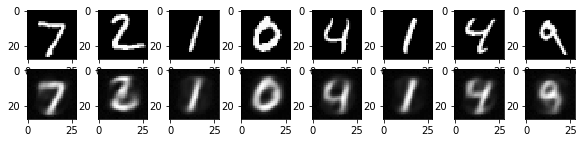

In [1]:
"""
예제 3-4: 희박 오토인코더: Pro Deep Learning + Hands on ML
"""

# 필요한 라이브러리를 불러들임
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# MNIST 데이터 읽어들임
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# 학습관련 매개변수 설정
learning_rate = 0.001
wgt_decay = 0.0001
sparse_penalty = 0.001
batch_size = 1000
display_step = 1
examples_to_show = 10

n_input = 28*28 # MNIST 데이터 입력 
n_hidden = 32*32 # 은닉노드 개수

# 입력, 가중치 및 편향을 정의함
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h': tf.Variable(tf.random_normal([n_input,n_hidden])),
    'decoder_h': tf.Variable(tf.random_normal([n_hidden,n_input])),
}    
biases = {
    'encoder_b': tf.Variable(tf.random_normal([n_hidden])),
    'decoder_b': tf.Variable(tf.random_normal([n_input])),
}

# 인코더를 구축함
def encoder(x):
    e_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h']),
                                   biases['encoder_b']))
    return e_layer

# 디코더를 구축함
def decoder(x):
    d_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, tf.transpose(weights['encoder_h'])),
                                   biases['decoder_b']))
    return d_layer

# Kullback Leibler 정보량 계산
def kl_div(rho, rho_hat):
    # Kullback Leibler divergence
    return rho * tf.log(rho / rho_hat) + (1 - rho) * tf.log((1 - rho) / (1 - rho_hat))

# 오토인코더 모형 구축
op_encoder = encoder(X)
op_decoder = decoder(op_encoder)
rho_hat = tf.reduce_mean(op_encoder,1)

# 예측값
y_true = X
y_pred = op_decoder

# 손실함수 및 최적화 정의 
loss_mse = tf.reduce_mean(tf.square(y_true - y_pred))
loss_reg = wgt_decay*tf.nn.l2_loss(weights['encoder_h'])
loss_sparse = sparse_penalty*tf.reduce_sum(kl_div(0.2,rho_hat))
loss = loss_mse + loss_reg + loss_sparse

optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# 텐서플로 그래프 실행
start_time = time.time()
with tf.Session() as sess:
	# 모형의 변수들을 초기화하기
    init = tf.global_variables_initializer()
    sess.run(init)
    num_batch = int(mnist.train.num_examples/batch_size)
    # 학습 과정
    num_epoch = 100
    for epoch in range(num_epoch):
        # 모든 미니배치에 대해 반복함
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, los = sess.run([optimizer, loss], feed_dict={X: batch_xs})
        # 실행 단계 보여주기
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "loss =", "{:.9f}".format(los))

    print("Optimization Finished!")

    # 검정 데이터 집합에 인코더와 디코더를 적용함
    n_digit = 8
    reconstruct_digit = sess.run(y_pred, feed_dict={X: mnist.test.images[:n_digit]})
    # 검정 데이터에 속하는 원래 이미지와 복원된 이미지를 비교함 
    fig, a = plt.subplots(2, n_digit, figsize=(10, 2))
    for i in range(n_digit):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)),cmap='gray')
        a[1][i].imshow(np.reshape(reconstruct_digit[i], (28, 28)),cmap='gray')
    # 인코더 및 디코더 관련 가중치를 저장함 
    w_encod = sess.run(weights['encoder_h'])
    w_decod = sess.run(weights['decoder_h'])
end_time = time.time()
print('elapsed time:',end_time - start_time)